In [1]:
import os
import sys
import dask
import uproot4
import numpy as np
import pandas as pd
from hist import Hist
import hist
import uproot4 as uproot
from dask.array import histogram as ds_hist
import dask.dataframe as dd
import timeit
from distributed import Client
import storage_functions as sf
import time
import psutil
import matplotlib.pyplot as plt
import pyarrow as pa
import re
import subprocess
from pympler import asizeof
import hist_vars
import itertools
import hist_wrapper
from hurry.filesize import size
import pyarrow.parquet as pq

In [2]:
dask.config.set({'temporary_directory': '/tmp/kmalirz'})

In [3]:
(Hist(hist.axis.Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]')))

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double())

In [4]:
#(sf.Histogram_wrapper(hist.axis.Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'),name='x'))

In [5]:
histo_var_dict = sf.combine_dicts([hist_vars.var_main, hist_vars.var_series, hist_vars.var_beta, 
                               hist_vars.var_ecf_beta, hist_vars.var_dichoric, hist_vars.var_ecfg])

In [6]:
#histo_var_dict = dict(itertools.islice(histo_var_dict.items(), 10))

In [7]:
len(histo_var_dict)

93

In [8]:
histogramming = sf.HistoMaker()

In [9]:
client = histogramming.client_start(n_workers = 4,memory_limit='5GB',threads_per_worker=1)

In [10]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 18.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34784,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 18.63 GiB
Comm: tcp://127.0.0.1:42307,Total threads: 1
Dashboard: http://127.0.0.1:34258/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:39889,


In [11]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [12]:

x = histogramming.create_file_list(top_directory = '/eos/atlas/atlascerngroupdisk/perf-jets/JSS/WTopBackgroundSF2019/UFO_test/slimmed_SEP_v2/',file_regex = '(?=^[^.].)(.*gammajet_210921.*|.*15.*)(.*h5$)')

In [13]:
size(sum([os.path.getsize(y) for y in x[:]]))

'6G'

In [14]:
#size(file_size)

In [15]:
len(x)

953

In [16]:
x[0]

'/eos/atlas/atlascerngroupdisk/perf-jets/JSS/WTopBackgroundSF2019/UFO_test/slimmed_SEP_v2/user.brle.305435.Sherpa.DAOD_JETM6.e5037_s3126_r10201_p4308.mc16d_gammajet_210921_sys_v2_output_root_0.h5'

In [17]:
data = histogramming.load_h5('Skl_Data/test12345.h5')

In [18]:
test = data.compute()

In [19]:
test.head(10)

leptons_pt        jets_pt   weight_mc  runNumber  \
event lep jet bdt                                                        
0     0   0   0    127083.039062  104784.437500  736.971985     284500   
              1    127083.039062  104784.437500  736.971985     284500   
              2    127083.039062  104784.437500  736.971985     284500   
              3    127083.039062  104784.437500  736.971985     284500   
              4    127083.039062  104784.437500  736.971985     284500   
          1   0    127083.039062  100864.882812  736.971985     284500   
              1    127083.039062  100864.882812  736.971985     284500   
              2    127083.039062  100864.882812  736.971985     284500   
              3    127083.039062  100864.882812  736.971985     284500   
              4    127083.039062  100864.882812  736.971985     284500   

                        BDT  
event lep jet bdt            
0     0   0   0    0.344902  
              1    0.367624  
              2    0.069904  
              3    0.010252  
              4    0.207318  
          1   0    0.344902  
              1    0.367624  
              2    0.069904  
              3    0.010252  
              4    0.207318

In [20]:
table = pa.Table.from_pandas(test)

pq.write_table(table, '/tmp/kmalirz/example.parquet')

table2 = pq.read_table('/tmp/kmalirz/example.parquet')

table2.to_pandas().head(10)

leptons_pt        jets_pt   weight_mc  runNumber  \
event lep jet bdt                                                        
0     0   0   0    127083.039062  104784.437500  736.971985     284500   
              1    127083.039062  104784.437500  736.971985     284500   
              2    127083.039062  104784.437500  736.971985     284500   
              3    127083.039062  104784.437500  736.971985     284500   
              4    127083.039062  104784.437500  736.971985     284500   
          1   0    127083.039062  100864.882812  736.971985     284500   
              1    127083.039062  100864.882812  736.971985     284500   
              2    127083.039062  100864.882812  736.971985     284500   
              3    127083.039062  100864.882812  736.971985     284500   
              4    127083.039062  100864.882812  736.971985     284500   

                        BDT  
event lep jet bdt            
0     0   0   0    0.344902  
              1    0.367624  
              2    0.069904  
              3    0.010252  
              4    0.207318  
          1   0    0.344902  
              1    0.367624  
              2    0.069904  
              3    0.010252  
              4    0.207318

In [21]:
df = dd.read_parquet('/tmp/kmalirz/example.parquet')

type(df)

dask.dataframe.core.DataFrame

In [22]:
df = df.repartition(npartitions=2)

df.npartitions

2

In [23]:
df.partitions[0].compute()

leptons_pt        jets_pt   weight_mc  runNumber  \
event lep jet bdt                                                        
0     0   0   0    127083.039062  104784.437500  736.971985     284500   
              1    127083.039062  104784.437500  736.971985     284500   
              2    127083.039062  104784.437500  736.971985     284500   
              3    127083.039062  104784.437500  736.971985     284500   
              4    127083.039062  104784.437500  736.971985     284500   
          1   0    127083.039062  100864.882812  736.971985     284500   
              1    127083.039062  100864.882812  736.971985     284500   
              2    127083.039062  100864.882812  736.971985     284500   
              3    127083.039062  100864.882812  736.971985     284500   
              4    127083.039062  100864.882812  736.971985     284500   

                        BDT  
event lep jet bdt            
0     0   0   0    0.344902  
              1    0.367624  
              2    0.069904  
              3    0.010252  
              4    0.207318  
          1   0    0.344902  
              1    0.367624  
              2    0.069904  
              3    0.010252  
              4    0.207318

In [24]:
histogramming.histogram_variables

{}

In [25]:
zzzzzz = data.compute()

In [26]:
zzzzzz

leptons_pt      jets_pt   weight_mc  runNumber       BDT
event lep jet bdt                                                             
0     0   0   0    127083.039062  104784.4375  736.971985     284500  0.344902
              1    127083.039062  104784.4375  736.971985     284500  0.367624
              2    127083.039062  104784.4375  736.971985     284500  0.069904
              3    127083.039062  104784.4375  736.971985     284500  0.010252
              4    127083.039062  104784.4375  736.971985     284500  0.207318
...                          ...          ...         ...        ...       ...
3681  0   3   0     89429.367188   48895.3125  735.537537     284500  0.151289
              1     89429.367188   48895.3125  735.537537     284500  0.329823
              2     89429.367188   48895.3125  735.537537     284500  0.144091
              3     89429.367188   48895.3125  735.537537     284500  0.116522
              4     89429.367188   48895.3125  735.537537     284500  0.258275

[91250 rows x 5 columns]

In [27]:
output = dask.compute(histogramming.fill(data,histo_var_dict))

In [28]:
output

([],)

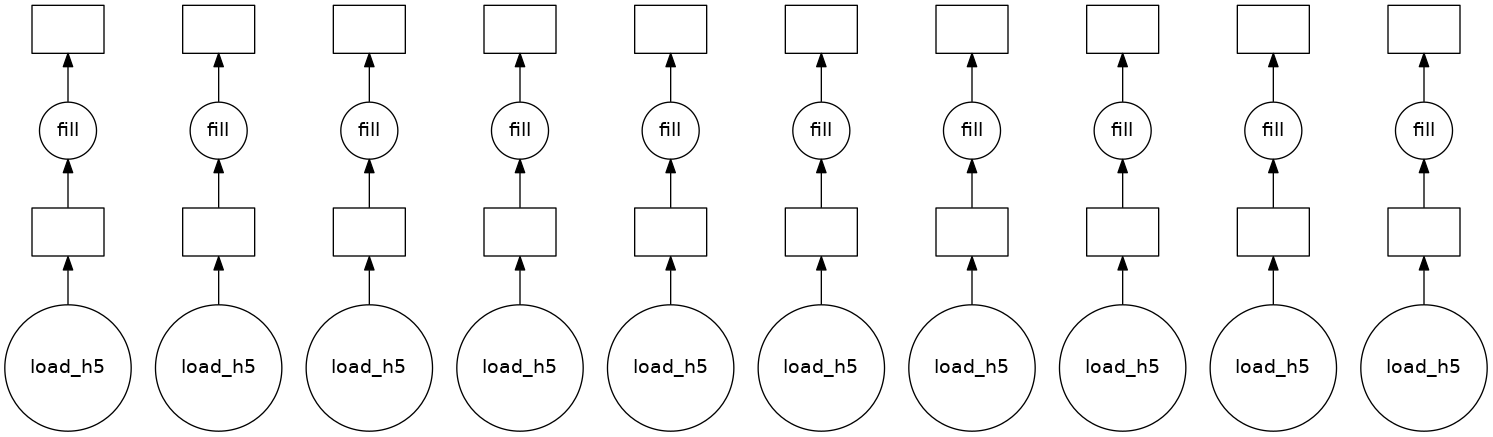

In [29]:
dask.visualize(histogramming.load_and_fill(file_list = x[:10]))

In [30]:
#%%time
#temp = dask.compute(histogramming.load_and_fill(data_column = 'rljet_pt_comb',file_list = x[:200]))

In [49]:
%%time
xxxxx = histogramming.compute_histograms(chunk_size = 100, histogram_variables = histo_var_dict, file_list = x[:])

done
done
done
done
done
done
done
done
done
done
CPU times: user 27.5 s, sys: 2.93 s, total: 30.5 s
Wall time: 58.8 s


In [32]:
a = histogramming.histograms_computed[1][0]
b = histogramming.histograms_computed[0][0]

a+b

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 24438.0 (75154.0 with flow)

In [33]:
len(histogramming.histograms_computed)


891

In [50]:
zzz, histograms_named = histogramming.combine_histograms()



In [51]:
histograms_named


{'rljet_pt_comb': Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 7904609.0 (16142323.0 with flow),
 'rljet_m_comb[:,0]': Hist(Regular(20, 50000, 500000, name='x', label='m [MeV]'), storage=Double()) # Sum: 16021483.0 (16142323.0 with flow),
 'rljet_Angularity': Hist(Regular(20, 0, 0.1, name='x', label='Angularity'), storage=Double()) # Sum: 16142323.0,
 'rljet_Aplanarity': Hist(Regular(20, 0, 1, name='x', label='Aplanarity'), storage=Double()) # Sum: 16142321.0 (16142323.0 with flow),
 'rljet_C2': Hist(Regular(20, 0, 1, name='x', label='$C_{2}$'), storage=Double()) # Sum: 16142321.0 (16142323.0 with flow),
 'rljet_D2': Hist(Regular(20, 0, 6, name='x', label='$D_{2}$'), storage=Double()) # Sum: 16121708.0 (16142323.0 with flow),
 'rljet_Dip12': Hist(Regular(20, 0, 2, name='x', label='Dip12'), storage=Double()) # Sum: 16135010.0 (16142323.0 with flow),
 'rljet_ECF1': Hist(Regular(20, 0, 1e+07, name='x', label='ECF$_{1}$'), storage=Double()) # S

In [53]:
len(histograms_named)

93

In [54]:
zzz[0]

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 7904609.0 (16142323.0 with flow)

In [38]:
for attribute, value in zzz[20].__dict__.items():
    print(attribute, '=', value)

name = None
label = None
_variance_known = False
metadata = None


In [39]:
len(xxxxx)

891

In [40]:
xxxxx[0][0]

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 7904609.0 (16142323.0 with flow)

In [41]:
min([len(x) for x in xxxxx])

93

In [42]:
#dask.visualize(histogramming.load_and_fill(data_column = 'rljet_pt_comb',file_list = x[:4]))

In [43]:
psutil.virtual_memory().percent

29.4

In [44]:
%%time
histogram_list = []
i = -1
for file in x[:20]:
    temp = pd.read_hdf(file)
    col_list = list(temp.columns)
    histogram_list.append([])
    i += 1
    for col in col_list:
        
        if histo_var_dict.get(col) != None:
            
            ssss = hist.Hist(histo_var_dict[col])
            ssss.fill(temp[col])
            histogram_list[i].append(ssss)
        
        

CPU times: user 2.56 s, sys: 1.76 s, total: 4.32 s
Wall time: 4.87 s


In [45]:
histogram_list[0][1]

Hist(Regular(20, 0, 1, name='x', label='Sphericity'), storage=Double()) # Sum: 27047.0

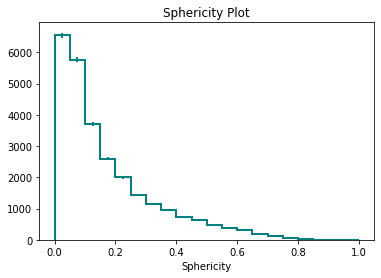

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.title("Sphericity Plot")
histogram_list[0][1].plot1d(ax=ax, ls="-", color="teal", lw=2)
plt.savefig("plot_test.jpeg")
plt.show()

In [47]:
type(ax)

matplotlib.axes._subplots.AxesSubplot